# Decoder


## Settings

In [45]:
from pipeline_utils import get_galaxy_filename

base = "tmp"
dataset = "nist"
kind = "in_database"


wv_path = f"../gas2vec/{kind}.model"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


data_rcx1_path = "../data/nist/rcx1_no_nist/train.msp"
data_rcx2_path = "../data/nist/rcx2_no_nist/train.msp"

data_realtest_path = get_galaxy_filename('Aplcms12', base, ["enh", "pred"])

%load_ext autoreload
%autoreload 2

import sys; sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from gensim.models import Word2Vec

w2v = Word2Vec.load(wv_path)
vocab = {e:i for i, e in enumerate(w2v.wv.index2entity)}
#vocab["unknown"] = -1


## Data loading

In [47]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from utils.data_utils import spectrum_processing
from utils.data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS, HuggDS
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

In [48]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None, n_required_peaks=1) for s in load_from_msp(path, metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents, spectrums

# documents_train = load_process_documents(data_train_path)
# documents_val = load_process_documents(data_val_path)
# documents_test = load_process_documents(data_test_path)
documents_supertest, spectrums_supertest = load_process_documents(data_realtest_path)


documents_rcx1, spectrums_rcx1 = load_process_documents(data_rcx1_path)
documents_rcx2, spectrums_rcx2 = load_process_documents(data_rcx2_path)

In [49]:
datasets = {
    # "hugg_train": HuggDS(documents_train, vocab, max_len=256), 
    # "hugg_val": HuggDS(documents_val, vocab, max_len=256), 
    # "hugg_test": HuggDS(documents_test, vocab, max_len=256),
    "hugg_supertest": HuggDS(documents_supertest, vocab, max_len=256),
    "hugg_rcx1": HuggDS(documents_rcx1, vocab, max_len=256),
    "hugg_rcx2": HuggDS(documents_rcx2, vocab, max_len=256),
}

dataloaders = {
    # "train": DataLoader(datasets["hugg_train"], batch_size=64, shuffle=True, num_workers=8),
    # "val": DataLoader(datasets["hugg_val"], batch_size=256, shuffle=True, num_workers=8),
    "test": None
}

## Models definition

In [50]:
import numpy as np
import torch
from transformers import GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config(n_positions=256, vocab_size=len(vocab)+1, \
                            bos_token_id=len(vocab), eos_token_id=len(vocab))#\
#                               pad_token_id=len(vocab))


In [51]:
# Initializing a model from the configuration
gpt2 = GPT2LMHeadModel(configuration)

# Accessing the model configuration
configuration = gpt2.config

configuration

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 1000,
  "embd_pdrop": 0.1,
  "eos_token_id": 1000,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 256,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.4.2",
  "use_cache": true,
  "vocab_size": 1001
}

In [52]:
gpt2.w2v = w2v

In [53]:
# discver whether to use GPU or not
use_cuda =  False#torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)

cpu


In [54]:
gpt2 = gpt2.to(device)

## Prediction

In [55]:
import torch.nn.functional as F


class PredictorDstGPT2():
    def __init__(self, model, coder_class, max_mz=None):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)

    @classmethod
    def from_file(cls, file, coder_cls, max_mz=None, device="cpu"):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, coder_class=coder_cls, max_mz=max_mz)
    
    
    def __call__(self, X_ds, device="cpu"):
        self.model= self.model.to(device)
        X_ds = X_ds.to(device)
        
        with torch.no_grad():
            # return distribution for next peak 
            return F.softmax(self.model(**{"input_ids":X_ds}).logits[:, len(X_ds[0])-1],  dim=-1)
    
    def predict_l_next(self, X_dict_batch, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        with torch.no_grad():
            logits = self.model(**X_dict_batch).logits[:, len(X_dict_batch["input_ids"][0])-1]
        
        if filtered:
            args_batch = torch.argsort(logits, dim=-1, descending=True).int().cpu()
            res = torch.empty((len(X_dict_batch["input_ids"]), l), dtype=torch.int)
            for i in range(len(args_batch)):
                given = set(X_dict_batch["input_ids"][i])
                solved = 0
                for j in range(len(args_batch[0])):
                    if args_batch[i][j] not in given:
                        res[i][solved] = args_batch[i][j]
                        solved +=1
                    if solved == l:
                        break
                
            return res.numpy()
        
        return torch.argsort(logits, dim=-1, descending=True)[:, :l].cpu().numpy()
        

    def predict_l_all(self, hugg_ds, up_to_k, l, batch_size=64, filtered=True, verbose=False, device="cpu"):
        
        self.model= self.model.to(device)
        
        #loader = DataLoader(hugg_ds, batch_size=batch_size, shuffle=True, num_workers=8)
        def loader_gen(ds, batch_size):
            keys= ds[0].keys()
            for i in range((len(ds)//batch_size)):
                n_sam = batch_size #if i*batch_size < len(ds) else len(ds) % batch_size
                batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
                for j in range(n_sam):
                    for key in keys:
                        batch[key][j] = ds[i*batch_size+j][key]
                yield batch
            
            n_sam = len(ds)% batch_size
            
            batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
            for j in range(n_sam):
                for key in keys:
                    batch[key][j] = ds[(i+1)*batch_size+j][key]
            yield batch
        
        loader = loader_gen(hugg_ds, batch_size)
        len_loader = len(hugg_ds)//batch_size + 1

        X_intens = [np.sort(doc.peaks.intensities)[::-1][:min(self.model.config.n_positions, len(doc.peaks.intensities))-1] for doc in hugg_ds.ref_docs]
        
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(hugg_ds), l)) * (-1)
        y_indices = []
        for b, X_dict_batch_ in enumerate(loader):
                
#             indices, intens = X_ds[:,0].numpy().astype(int), X_ds[:,1].numpy()
            y_indices += [arr[(X_dict_batch_["attention_mask"][u]==1).numpy()][1:] for u, arr in enumerate((X_dict_batch_["input_ids"].numpy().astype(int)))]            
    #             X_intens.append(intens)
            for j in range(1, up_to_k+1):
                # we skip evaluation for too short spectra
#                 if j > len(indices):
#                     continue
               # print(j)
                X_dict_batch = {"input_ids": X_dict_batch_["input_ids"][:, :j].clone()}#{k: v.detach().clone() for k, v in X_dict_batch_.items()}
                
               # drop too short spectra
                # get mask - for each sample in batch either True (long enough) or False (too short) 
                len_mask = X_dict_batch_["attention_mask"][:, j-1] == 1
                
                X_dict_batch["input_ids"] = X_dict_batch["input_ids"][len_mask]

                # no samples in batch left after cutting 
                if len_mask.sum() == 0:
                    continue
                X_dict_batch = {k: v.to(device) for k, v in X_dict_batch.items()}

                l_next = self.predict_l_next(X_dict_batch, l, filtered, device=device)
                
                l_pred_indices_per_k[j-1,b*batch_size: (b+1)*(batch_size)][len_mask] = l_next
            
            if verbose and b % 1 == 0:
                print(f"Done: {b}/{len_loader}")
        return l_pred_indices_per_k, y_indices, X_intens 


class PredictorAutoGPT2():
    def __init__(self, model, coder_class, max_mz=None):
        self.model = model
        self.coder = coder_class(model.w2v, max_mz)

    @classmethod
    def from_file(cls, file, coder_cls, max_mz=None, device="cpu"):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, coder_class=coder_cls, max_mz=max_mz)
    
    
    def __call__(self, X_ds, device="cpu"):
        self.model= self.model.to(device)
        X_ds = X_ds.to(device)
        
        with torch.no_grad():
            # return distribution for next peak 
            return F.softmax(self.model(**{"input_ids":X_ds}).logits[:, len(X_ds[0])-1], dim=-1)
    
    def predict_l_next(self, X_dict_batch, l, filtered=True, device="cpu"):
        """
        receives indices and intens and predicts l next peaks
        if filtered: returns only non-repetitive indices that are not given as input
        """
        
        k = X_dict_batch["input_ids"].shape[1]

        if filtered:
            return self.model.generate(
                X_dict_batch["input_ids"], 
                max_length=k+l, 
                #num_beams=5, 
                no_repeat_ngram_size=1, 
                #encoder_no_repeat_ngram_size=1,
                #early_stopping=True, 
                #bad_words_ids = X_dict_batch["input_ids"].tolist(),
                pad_token_id=len(self.coder.vocab)
            ).cpu().numpy()[:, k:]

#             res = torch.empty(len(X_dict_batch["input_ids"]), l, dtype=torch.int) 
#             for i in range(len(beam_output)):
#                 uniq_row = torch.unique(beam_output[i])
#                 assert len(uniq_row) >= l 
#                 res[i, :] = uniq_row[:l]
#             return res
            
        
        return self.model.generate(
                X_dict_batch["input_ids"], 
                max_length=k+l, 
                #num_beams=5, 
                #early_stopping=True, 
                pad_token_id=len(self.coder.vocab)
        ).cpu().numpy()[:, k:]
        
#       
    def predict_l_all(self, hugg_ds, up_to_k, l, batch_size=64, filtered=True, verbose=False, device="cpu"):
        self.model= self.model.to(device)
        
        #loader = DataLoader(hugg_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        def loader_gen(ds, batch_size):
            keys= ds[0].keys()
            for i in range((len(ds)//batch_size)):
                n_sam = batch_size #if i*batch_size < len(ds) else len(ds) % batch_size
                batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
                for j in range(n_sam):
                    for key in keys:
                        batch[key][j] = ds[i*batch_size+j][key]
                yield batch
            
            n_sam = len(ds)% batch_size
            
            batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
            for j in range(n_sam):
                for key in keys:
                    batch[key][j] = ds[(i+1)*batch_size+j][key]
            yield batch
            
        loader = loader_gen(hugg_ds, batch_size)
        len_loader = len(hugg_ds)//batch_size + 1
        X_intens = [np.sort(doc.peaks.intensities)[::-1][:min(self.model.config.n_positions, len(doc.peaks.intensities))-1] for doc in hugg_ds.ref_docs]

        
        l_pred_indices_per_k = np.ones(shape=(up_to_k, len(hugg_ds), l)) * (-1)
        y_indices = []

        for b, X_dict_batch_ in enumerate(loader):
                
#             indices, intens = X_ds[:,0].numpy().astype(int), X_ds[:,1].numpy()
            y_indices += [arr[(X_dict_batch_["attention_mask"][u]==1).numpy()][1:] for u, arr in enumerate((X_dict_batch_["input_ids"].numpy().astype(int)))]
#             X_intens.append(intens)
            for j in range(1, up_to_k+1):
                # we skip evaluation for too short spectra
#                 if j > len(indices):
#                     continue
               # print(j)
                X_dict_batch = {"input_ids": X_dict_batch_["input_ids"][:, :j].clone()}#{k: v.detach().clone() for k, v in X_dict_batch_.items()}
                
                # drop too short spectra
                # get mask - for each sample in batch either True (long enough) or False (too short) 
                len_mask = X_dict_batch_["attention_mask"][:, j-1] == 1
                
                X_dict_batch["input_ids"] = X_dict_batch["input_ids"][len_mask]

                # no samples in batch left after cutting 
                if len_mask.sum() == 0:
                    continue
                X_dict_batch = {k: v.to(device) for k, v in X_dict_batch.items()}

                l_next = self.predict_l_next(X_dict_batch, l, filtered, device=device)
                
                l_pred_indices_per_k[j-1,b*batch_size: (b+1)*(batch_size)][len_mask] = l_next
            
            if verbose and b % 1 == 0:
                print(f"Done: {b}/{len_loader}")
        return l_pred_indices_per_k, y_indices, X_intens 

## Model Selection
done on the val set

In [56]:
import os
from utils.metrics import metrics_klj, metrics_intlj

predictors = { 
            "gpt2_first_dst": PredictorDstGPT2.from_file(f"../models/{kind}/gpt2", TextMzCoder, max_mz=None, device=device),
            "gpt2_ns_dst": PredictorDstGPT2.from_file(f"../models/{kind}/gpt2_lr5e-5_ns", TextMzCoder, max_mz=None, device=device),  
            "gpt2_dst": PredictorDstGPT2.from_file(f"../models/{kind}/gpt2_lr5e-5", TextMzCoder, max_mz=None, device=device),  
            "gpt2_first_auto": PredictorAutoGPT2.from_file(f"../models/{kind}/gpt2", TextMzCoder, max_mz=None, device=device),
            "gpt2_auto": PredictorAutoGPT2.from_file(f"../models/{kind}/gpt2_lr5e-5", TextMzCoder, max_mz=None, device=device),
            "gpt2_ns_auto": PredictorAutoGPT2.from_file(f"../models/{kind}/gpt2_lr5e-5_ns", TextMzCoder, max_mz=None, device=device),
                
             }

P_FOLDER = f"predictions/{kind}"
up_to_k = 30
l = 20

In [57]:
best_p_name = "gpt2_ns_auto"

## Simulated test on rcx libraries

In [58]:
from utils.model_evaluation import calc_predictions, load_predictions, model_selection
from utils.visual_utils import plot_scores

In [29]:
%%time
calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, datasets, "hugg_rcx1", P_FOLDER, batch_size=100, device=device, verbose=False)
calc_predictions(up_to_k, l, {best_p_name: predictors[best_p_name]}, datasets, "hugg_rcx2", P_FOLDER, batch_size=100, device=device, verbose=False)

gpt2_ns_auto


/storage/brno2/home/xstary1/brno6/.local-Pytorch-21.SIF/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


gpt2_ns_auto
CPU times: user 1h 2min 15s, sys: 6.82 s, total: 1h 2min 22s
Wall time: 1h 2min 23s


gpt2_ns_auto
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
Selected up to k=20, l=None, to_rel_inten=0.2
[352 384 386 386 386 385 384 382 382 378 377 373 369 363 359 353 346 341
 335 329]
gpt2_first_dst
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
Selected up to k=20, l=None, to_rel_inten=0.2
[352 384 386 386 386 385 384 382 382 378 377 373 369 363 359 353 346 341
 335 329]


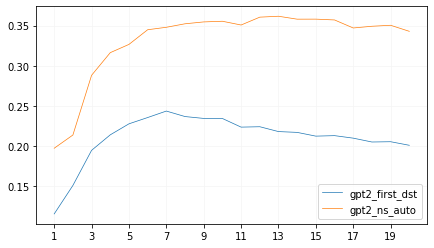

In [30]:
best_p_name, scores = model_selection(P_FOLDER, "hugg_rcx1", predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)
plot_scores(scores, metrics="mpi")

gpt2_ns_auto
Possible k up to 30, predict up to 20 peaks
Selected up to k=20, l=4, j=6
Selected up to k=20, l=None, to_rel_inten=0.2
[243 263 265 265 265 265 265 265 264 264 264 263 260 260 258 255 251 245
 243 240]


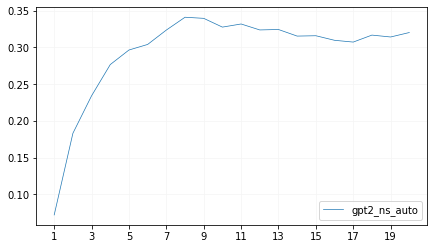

In [31]:
best_p_name, scores = model_selection(P_FOLDER, "hugg_rcx2", predictors=predictors, up_to_k=20, \
                                      l=4, j=6, to_rel_inten=.2, l_rel=None)
plot_scores(scores, metrics="mpi")

## Supertest

In [59]:
hugg_ds = datasets["hugg_supertest"]
batch_size = 1
predictor = predictors[best_p_name]

In [60]:
def loader_gen(ds, batch_size):
    keys= ds[0].keys()
    for i in range((len(ds)//batch_size)):
        n_sam = batch_size #if i*batch_size < len(ds) else len(ds) % batch_size
        batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
        for j in range(n_sam):
            for key in keys:
                batch[key][j] = ds[i*batch_size+j][key]
        yield batch
            
    n_sam = len(ds)% batch_size
            
    batch = {k: torch.empty(n_sam, *v.shape, dtype=v.dtype) for k,v in ds[0].items()}
    for j in range((len(ds)%batch_size)):
        for key in keys:
            batch[key][j] = ds[(i+1)*batch_size+j][key]
        yield batch
            
loader = loader_gen(hugg_ds, batch_size)
len_loader = len(hugg_ds)//batch_size + 1
X_intens = [np.sort(doc.peaks.intensities)[::-1][:min(predictor.model.config.n_positions, len(doc.peaks.intensities))-1] for doc in hugg_ds.ref_docs]

datasets["hugg_supertest"]

In [61]:
predictor.coder.vocab["peak@115"]

36

In [62]:
len(hugg_ds)

165

In [63]:
from tqdm import tqdm
preds = []
for b, X_dict_batch_ in enumerate(tqdm(loader)):
    #print(X_dict_batch_)
    X_dict_batch = {"input_ids": torch.atleast_2d(X_dict_batch_["input_ids"][X_dict_batch_["attention_mask"] == 1])}
    #print(X_dict_batch)
    pred = predictor.predict_l_next(X_dict_batch, l=10)[0]
    pred = predictor.coder.index2mz[pred]
    preds.append(pred)

165it [00:55,  2.99it/s]


In [64]:
len(preds)

165

In [65]:
hugg_ds.ref_docs[0]

In [66]:
spectrums_supertest[1].metadata

{'ionmode': 'Negative',
 'spectrumtype': 'Centroid',
 'num_peaks': '14',
 'compound_name': 'C054',
 'retention_time': '122.71',
 'retention_index': '1086.803543'}

In [67]:
spectrums_supertest[0].peaks.mz

array([ 71.04915347,  72.05249114,  72.05694212,  73.06470108,
        75.01034223,  76.0181442 ,  78.01498857,  78.03385321,
        78.8680084 ,  79.04161366,  79.92556941,  80.03861506,
        80.04493783,  86.06807381,  86.07251984,  94.98921529,
        99.08040703, 100.08375533, 100.08824961, 110.10901314,
       112.12459057, 114.09945172, 120.08875599, 127.02389138,
       127.11156231, 136.94158535, 142.13516842, 176.06747288,
       282.07660862, 302.12101639])

In [68]:
from utils.prediction_utils import enhance_spectra, predict_spectra
        
enhanced_spectra = [*enhance_spectra(spectrums_supertest, preds, 5)]
predicted_spectra = [*predict_spectra(spectrums_supertest, preds, 5)]


In [69]:
from matchms.exporting import save_as_msp

In [70]:
# save_as_msp(enhanced_spectra, f"{data_realtest_path[:-4]}_enh_GPT2_5.msp")
save_as_msp(predicted_spectra, f"{data_realtest_path[:-4]}_pred_GPT2_5.msp")


In [ ]:
# put(f"{data_realtest_path[:-4]}_enh_GPT2_5.msp")
# put(f"{data_realtest_path[:-4]}_pred_GPT2_5.msp")